<a href="https://colab.research.google.com/github/hzg139/picar/blob/master/picar_tensorflow_traffic_sign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PiCar交通标志对象识别模型训练

使用自己的交通标志对象训练成模型，在picar中使用这个模型进行识别，并实现根据交通标志完成简单的自动驾驶。



# 第一步: 挂载google drive
训练完成的模型将输出到google drive中，设置好google drive中的文件路径。


In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:

from google.colab import drive
drive.mount('/content/gdrive')

model_dir = '/content/gdrive/My Drive/Colab Notebooks/DeepLearning/Training'
#!rm -rf '{model_dir}'
#os.makedirs(model_dir, exist_ok=True)
!ls -ltra '{model_dir}'/..

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
total 4
drwx------ 2 root root 4096 Feb 15 12:50 Training


# 第二步: 配置训练环境

参考 [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), 然后配置文件 [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [0]:
# 项目github路径.
repo_url = 'https://github.com/hzg139/picar'

# Number of training steps.
num_steps = 1000  # 200000
#num_steps = 100  # 200000

# Number of evaluation steps.
num_eval_steps = 50


# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 12
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
# Note: for Edge TPU, you have to:
# 1) start with a pretrained model from model zoo, such as above 4
# 2) Must be a quantized model, which reduces the model size significantly
selected_model = 'ssd_mobilenet_v2_quantized'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## 下载github代码.
需要训练的图片存放在`data/images/`下，有个目录`/test` `/train`

In [0]:
import os

%cd /content
#项目代码存放位置
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

!git pull

/content
Cloning into 'picar'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 124 (delta 49), reused 124 (delta 49), pack-reused 0
Receiving objects: 100% (124/124), 7.50 MiB | 1.23 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/picar
Already up to date.


## 安装Tensorflow环境及相关依赖包

In [0]:
#tensorflow环境安装
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 145113 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

## 准备 `tfrecord` 文件

用下面的命令生成tfrecord文件


In [0]:
%cd {repo_dir_path}/object_detection

# 将train目录下的xml标签文件转换为csv
!python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# 转换test目录下的xml标签为csv
!python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# 生成 `train.record` --> label_map.pbtxt
!python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# 生成 `test.record`  --> label_map.pbtxt
!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/picar/object_detection
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.


W0219 08:59:50.163891 140277817386880 module_wrapper.py:139] From generate_tfrecord.py:105: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0219 08:59:50.171656 140277817386880 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:138: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/picar/object_detection/data/annotations/train.record


W0219 08:59:55.271466 140640140973952 module_wrapper.py:139] From generate_tfrecord.py:105: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0219 08:59:55.277609 140640140973952 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:138: The name tf.gfile.GFile is

In [0]:
test_record_fname = repo_dir_path + '/object_detection/data/annotations/test.record'
train_record_fname = repo_dir_path + '/object_detection/data/annotations/train.record'
label_map_pbtxt_fname = repo_dir_path + '/object_detection/data/annotations/label_map.pbtxt'

In [0]:
#查看分类标签
!cat data/annotations/test_labels.csv

filename,width,height,class,xmin,ymin,xmax,ymax
42.jpg,800,600,turn_left,126,127,208,195
42.jpg,800,600,limit_80,263,133,329,195
42.jpg,800,600,limit_40,370,137,434,200
42.jpg,800,600,turn_right,472,137,552,205
42.jpg,800,600,stop,585,151,655,213
42.jpg,800,600,person,416,245,496,363
50.jpg,800,600,turn_left,60,104,171,189
50.jpg,800,600,limit_80,242,101,326,186
50.jpg,800,600,limit_40,382,106,459,184
50.jpg,800,600,turn_right,511,103,613,185
50.jpg,800,600,stop,653,109,745,190
50.jpg,800,600,person,463,245,572,399
28.jpg,800,600,stop,81,158,177,237
28.jpg,800,600,turn_right,222,151,311,227
28.jpg,800,600,limit_40,403,157,475,227
28.jpg,800,600,turn_left,529,158,618,229
28.jpg,800,600,limit_80,688,156,771,230
28.jpg,800,600,person,296,287,401,447
31.jpg,800,600,stop,272,180,317,221
31.jpg,800,600,turn_right,339,175,389,219
31.jpg,800,600,limit_40,435,186,479,231
31.jpg,800,600,turn_left,506,197,561,245
31.jpg,800,600,limit_80,595,208,649,256
31.jpg,800,600,person,355,266,410,337
10.jpg

## 下载Base Model

In [0]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
#根据之前配置的ssd_mobilenet_v2模型为基础模型
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [0]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 204M
drwx------  2 303230 5000 4.0K Jan  4  2019 .
drwxr-xr-x 65 root   root 4.0K Feb 19 09:00 ..
-rw-------  1 303230 5000  93M Jan  4  2019 model.ckpt.data-00000-of-00001
-rw-------  1 303230 5000  68K Jan  4  2019 model.ckpt.index
-rw-------  1 303230 5000  20M Jan  4  2019 model.ckpt.meta
-rw-------  1 303230 5000 4.3K Jan  4  2019 pipeline.config
-rw-------  1 303230 5000  24M Jan  4  2019 tflite_graph.pb
-rw-------  1 303230 5000  68M Jan  4  2019 tflite_graph.pbtxt


In [0]:
#输出基础模型路径
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

# 第三步: 模型训练

## 配置一个训练的管道

In [0]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [0]:
import re

# training pipeline file defines:
# - pretrain model path
# - the train/test sets
# - ID to Label mapping and number of classes
# - training batch size
# - epochs to trains
# - learning rate
# - etc

# note we just need to use a sample one, and make edits to it.

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint: downloaded pre-trained model checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test, we created earlier with our training/test sets
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path: ID to label file
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps (Number of epochs to train)
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [0]:
!cat {label_map_pbtxt_fname}

item {
    id: 1
    name: 'limit_40'
}

item {
    id: 2
    name: 'limit_80'
}

item {
    id: 3
    name: 'person'
}

item {
    id: 4
    name: 'stop'
}

item {
    id: 5
    name: 'turn_left'
}

item {
    id: 6
    name: 'turn_right'
}

In [0]:
# 查看分类数: 6, 包括 5 个交通标志和 1个人物标志 
!cat {pipeline_fname}

# Quantized trained SSD with Mobilenet v2 on MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 6
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspe

## 运行Tensorboard
可进入Tensorboard中查看训练进度及结果

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-02-16 09:50:52--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.203.240.15, 52.201.174.2, 52.203.65.11, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.203.240.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  38.0MB/s    in 0.3s    

2020-02-16 09:50:53 (38.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir "{}" --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

### 获取 Tensorboard 链接

In [0]:
#输出 tensorboard访问链接
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://d69f7cb9.ngrok.io


## 模型训练

In [0]:
num_steps = 2000
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir='{model_dir}' \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0216 10:13:08.745704 139956739245952 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0216 10:13:08.749490 139956739245952 module_wrapper.py:139] From /content/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0216 10:13:08.749670 139956739245952 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0216 10:13:08.749781 139956739245952 module_wrapper.py:139] From /content/models/resea

In [0]:
!ls -ltra '{model_dir}'

total 593020
drwx------ 2 root root     4096 Feb 16 10:03 eval_0
-rw------- 1 root root 59040451 Feb 16 10:12 events.out.tfevents.1581846753.3414639e6aa2
-rw------- 1 root root 30718973 Feb 16 10:14 graph.pbtxt
-rw------- 1 root root    68804 Feb 16 14:16 model.ckpt-1754.index
-rw------- 1 root root 75237296 Feb 16 14:16 model.ckpt-1754.data-00000-of-00001
-rw------- 1 root root 16378341 Feb 16 14:16 model.ckpt-1754.meta
-rw------- 1 root root    68804 Feb 16 14:26 model.ckpt-1824.index
-rw------- 1 root root 75237296 Feb 16 14:26 model.ckpt-1824.data-00000-of-00001
-rw------- 1 root root 16378341 Feb 16 14:26 model.ckpt-1824.meta
-rw------- 1 root root    68804 Feb 16 14:36 model.ckpt-1894.index
-rw------- 1 root root 75237296 Feb 16 14:36 model.ckpt-1894.data-00000-of-00001
-rw------- 1 root root 16378341 Feb 16 14:36 model.ckpt-1894.meta
-rw------- 1 root root    68804 Feb 16 14:46 model.ckpt-1963.index
-rw------- 1 root root 75237296 Feb 16 14:46 model.ckpt-1963.data-00000-of-00001

# 第四步:导出训练模型

## 导出模型
训练工作完成后，需要提取新训练的模型作为推理图，以后将用于执行对象检测

In [0]:
import os
import re
import numpy as np

output_directory = '%s/fine_tuned_model' % model_dir
os.makedirs(output_directory, exist_ok=True)

In [0]:
lst = os.listdir(model_dir)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)


/content/gdrive/My Drive/Colab Notebooks/DeepLearning/Training/model.ckpt-2000


In [0]:
!echo creates the frozen inference graph in fine_tune_model
# there is an "Incomplete shape" message.  but we can safely ignore that. 
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

creates the frozen inference graph in fine_tune_model
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0219 09:01:45.875196 140468060276608 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0219 09:01:45.880507 140468060276608 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0219 09:01:45.881170 140468060276608 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:121: The name tf.placeholder is 

In [0]:
!ls {output_directory}

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/Colab': No such file or directory
ls: cannot access 'Notebooks/DeepLearning/Training/fine_tuned_model': No such file or directory


## 下载 `.pb` 模型

### 转换为Tensorflow Lite模型

In [0]:
# https://medium.com/tensorflow/training-and-serving-a-realtime-mobile-object-detector-in-30-minutes-with-cloud-tpus-b78971cf1193
# create the tensorflow lite graph
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fname} \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0219 09:03:07.652884 140410474813312 module_wrapper.py:139] From /content/models/research/object_detection/export_tflite_ssd_graph.py:133: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0219 09:03:07.655977 140410474813312 module_wrapper.py:139] From /content/models/research/object_detection/export_tflite_ssd_graph_lib.py:193: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0219 09:03:07.656657 140410474813312 module_wrapper.py:139] From /content/models/research/object_detection/export_tflite_ssd_graph_lib.py:237: The name tf.placeholder is deprecated. Ple

In [0]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to quantized TF Lite file...
Python 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> exit()
2020-02-19 09:05:05.490550: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-02-19 09:05:05.515715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-02-19 09:05:05.516306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla P4 major: 6 minor: 1 memoryClockRate(GHz): 1.1135
pciBusID: 0000:00:04.0
2020-02-19 09:05:05.516549: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-02-19 09:05:05.518236: I tensorflow/stream_executor/platform/default/dso_loader.cc

下载文件

In [0]:
import os
# frozen graph
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)
#tflite 模型
tflite_fname = os.path.join(os.path.abspath(output_directory), "road_signs_quantized.tflite")
assert os.path.isfile(tflite_fname), '`{}` not exist'.format(tflite_fname)

In [0]:
#显示pb文件路径
!ls -alh {pb_fname}

ls: cannot access '{pb_fname}': No such file or directory


In [0]:
from google.colab import files
#下载到本地
files.download(pb_fname)
files.download(tflite_fname)

## 下载lable_map.pbtxt及pipline文件

In [0]:
from google.colab import files
files.download(label_map_pbtxt_fname)
#download pipline
files.download(pipeline_fname)

## 运行测试
使用 `object_detection/data/images/test` 目录中的图片进行测试.

In [0]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname
print(PATH_TO_CKPT)

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "object_detection/data/images/test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/content/gdrive/My Drive/Colab Notebooks/DeepLearning/Training/fine_tuned_model/frozen_inference_graph.pb
['/content/picar/object_detection/data/images/test/10.jpg', '/content/picar/object_detection/data/images/test/42.jpg', '/content/picar/object_detection/data/images/test/31.jpg', '/content/picar/object_detection/data/images/test/28.jpg', '/content/picar/object_detection/data/images/test/50.jpg']


In [0]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict



/content/models/research/object_detection


Running inferences on ['/content/picar/object_detection/data/images/test/10.jpg', '/content/picar/object_detection/data/images/test/42.jpg', '/content/picar/object_detection/data/images/test/31.jpg', '/content/picar/object_detection/data/images/test/28.jpg', '/content/picar/object_detection/data/images/test/50.jpg']


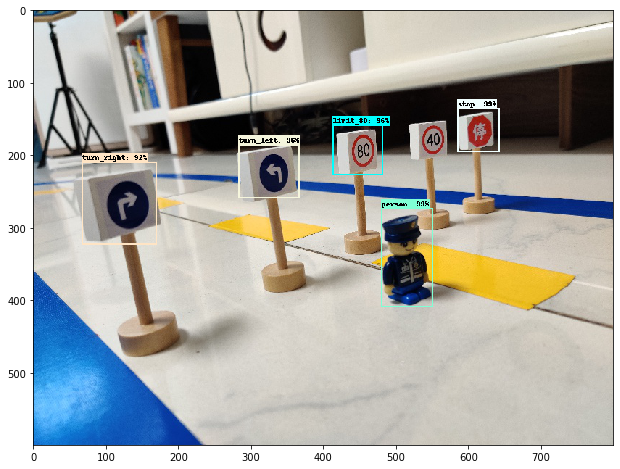

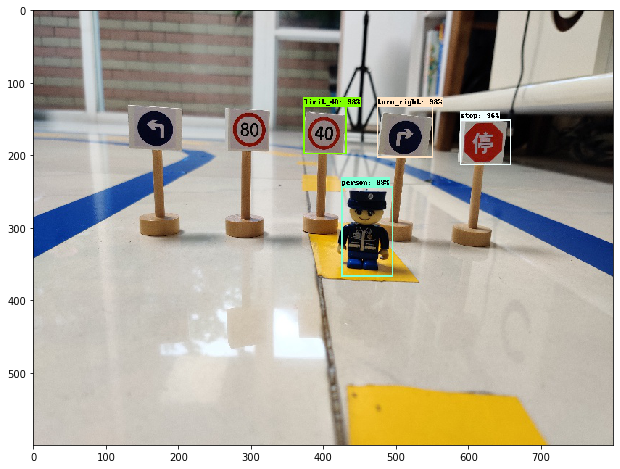

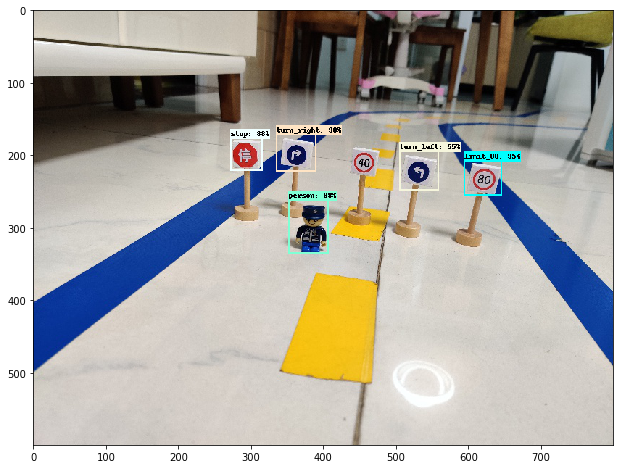

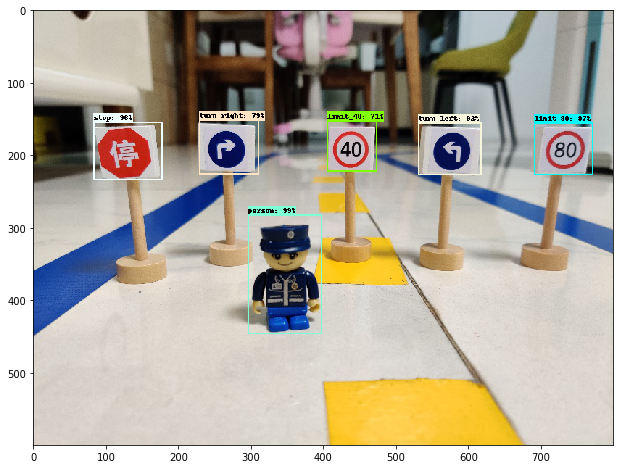

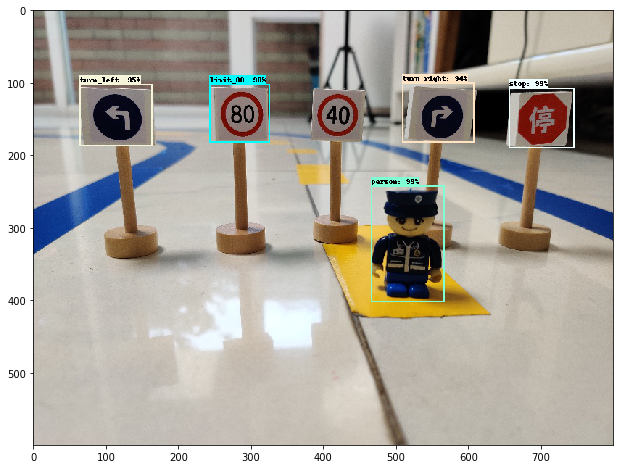

In [0]:
# running inferences.  This should show images with bounding boxes
%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)